In [1]:
import pandas as pd
import numpy as np

import xgboost as xg
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option("display.max_columns", None)

data = pd.read_csv('../data/chi_df_cleaned.csv')
data.head()

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,turning_loop,sunrise_sunset,civil_twilight,nautical_twilight,astronomical_twilight,start_time_ep,end_time_ep,weather_timestamp_ep,year,month,week,accident_duration,side_L,side_R,wind_direction_CALM,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_VAR,wind_direction_W,wind_direction_WNW,wind_direction_WSW,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Heavy Rain,weather_condition_Heavy Snow,weather_condition_Light Drizzle,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain Showers,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Rain,weather_condition_Snow,weather_condition_Thunder,weather_condition_Thunderstorms and Rain,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_condition_Light Snow and Sleet,is_DST
0,2,42.305960,-87.960150,42.306916,-87.960918,0.077,37.0,31.0,79.0,29.59,10.0,8.1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480517e+09,1.480539e+09,1.480518e+09,2016,11,48,21600.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,42.175870,-88.135770,42.174620,-88.135794,0.086,37.0,28.1,76.0,29.62,10.0,15.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480518e+09,1.480540e+09,1.480518e+09,2016,11,48,21600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,42.175897,-88.135769,42.174612,-88.135794,0.089,37.0,28.1,76.0,29.62,10.0,15.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480519e+09,1.480541e+09,1.480518e+09,2016,11,48,22524.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,41.860591,-87.992749,41.860590,-87.992700,0.003,37.0,30.4,76.0,29.61,10.0,9.2,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.480522e+09,1.480544e+09,1.480522e+09,2016,11,48,21600.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,3,41.750330,-87.663440,41.750330,-87.663440,0.000,37.9,30.0,73.0,29.65,10.0,12.7,0.0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.0,0.0,0.0,0.0,1.480524e+09,1.480545e+09,1.480524e+09,2016,11,48,21600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [3]:
X = data.drop(['severity'], axis=1)
y = data['severity']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [4]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (30729, 112)
y_train shape: (30729,)
X_test shape: (10244, 112)
y_test shape: (10244,)


In [5]:
def compare_preds(true, preds):
    compare = pd.DataFrame([true.value_counts(normalize=True).sort_index().index, true.value_counts(normalize=True).sort_index().values, pd.DataFrame(preds).value_counts(normalize=True).sort_index().values]).T
    return pd.DataFrame(compare).rename(columns={0:'Severity',1:'True Label Distribution',2:'Predicted Label Distribution'}).set_index('Severity')

In [6]:
def print_scores(model_name, model, xtrain, ytrain, xtest, ytest, preds):
    print(f'{model_name} Accuracy Scores')
    print('-'*53)
    print(f'{model_name} Training:', model.score(xtrain,ytrain))
    print(f'{model_name} Testing:', model.score(xtest,ytest))
    print('-'*53)
    print('Classification Report')
    print('-'*53)
    print(classification_report(y_test, preds, zero_division=0))
    plot_confusion_matrix(model, xtest, ytest);

[21:47:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost Accuracy Scores
-----------------------------------------------------
XGBoost Training: 0.9133391909922224
XGBoost Testing: 0.8489847715736041
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.48      0.23      0.31        62
           2       0.85      0.87      0.86      4226
           3       0.86      0.89      0.88      5200
           4       0.77      0.45      0.57       756

    accuracy                           0.85     10244
   macro avg       0.74      0.61      0.65     10244
weighted avg       0.85      0.85      0.84     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.002831
2.0,0.412491,0.426005
3.0,0.507627,0.528016
4.0,0.073805,0.043147


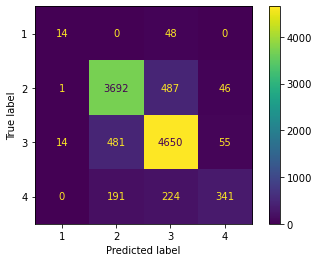

In [7]:
xg_model = xg.sklearn.XGBClassifier()
xg_model.fit(X_train,y_train)
xg_preds = xg_model.predict(X_test)
print_scores('XGBoost', xg_model, X_train, y_train, X_test, y_test, xg_preds)
compare_preds(y,xg_preds)

Decision Tree Accuracy Scores
-----------------------------------------------------
Decision Tree Training: 0.7990823001073905
Decision Tree Testing: 0.788266302225693
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.78      0.82      0.80      4226
           3       0.80      0.88      0.84      5200
           4       0.54      0.06      0.12       756

    accuracy                           0.79     10244
   macro avg       0.53      0.44      0.44     10244
weighted avg       0.77      0.79      0.76     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.432546
2.0,0.412491,0.558571
3.0,0.507627,0.008883
4.0,0.073805,NaN


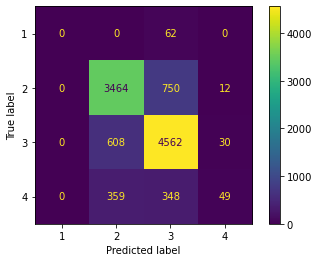

In [8]:
# decision tree model with just a few hyperparameters
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=5)
tree.fit(X_train,y_train)
tree_preds = tree.predict(X_test)
print_scores('Decision Tree', tree, X_train, y_train, X_test, y_test, tree_preds)
compare_preds(y,tree_preds)

In [9]:
tree_coefs = pd.DataFrame(zip(X_train.columns, tree.feature_importances_), columns=['feature','coefficient'])
tree_coefs[tree_coefs['coefficient'] > 0][:15].sort_values(by='coefficient', ascending=False)

,feature,coefficient
26,civil_twilight,0.108485
4,distance(mi),0.051600
3,end_lng,0.011220
1,start_lng,0.010020
2,end_lat,0.008957
23,traffic_signal,0.005516
0,start_lat,0.004740
8,pressure(in),0.004235
6,wind_chill(f),0.002653
5,temperature(f),0.001229


Random Forrest Accuracy Scores
-----------------------------------------------------
Random Forrest Training: 0.8045819909531713
Random Forrest Testing: 0.7897305739945334
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.80      0.81      0.80      4226
           3       0.78      0.90      0.84      5200
           4       0.94      0.02      0.04       756

    accuracy                           0.79     10244
   macro avg       0.63      0.43      0.42     10244
weighted avg       0.80      0.79      0.76     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.415365
2.0,0.412491,0.583073
3.0,0.507627,0.001562
4.0,0.073805,NaN


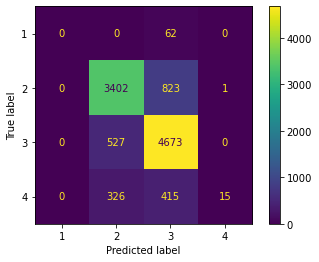

In [10]:
forrest = RandomForestClassifier(max_depth=10)
forrest.fit(X_train,y_train)
forrest_preds = forrest.predict(X_test)
print_scores('Random Forrest', forrest, X_train, y_train, X_test, y_test, forrest_preds)
compare_preds(y,forrest_preds)

BAG Classifier Accuracy Scores
-----------------------------------------------------
BAG Classifier Training: 0.9903023202837711
BAG Classifier Testing: 0.8357087075361187
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.33      0.06      0.11        62
           2       0.82      0.87      0.85      4226
           3       0.85      0.88      0.86      5200
           4       0.79      0.43      0.56       756

    accuracy                           0.84     10244
   macro avg       0.70      0.56      0.59     10244
weighted avg       0.83      0.84      0.83     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.001171
2.0,0.412491,0.434108
3.0,0.507627,0.524112
4.0,0.073805,0.040609


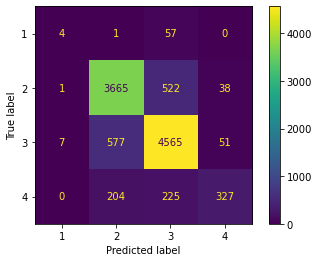

In [11]:
bag = BaggingClassifier(bootstrap_features=True)
bag.fit(X_train,y_train)
bag_preds = bag.predict(X_test)
print_scores('BAG Classifier', bag, X_train, y_train, X_test, y_test, bag_preds)
compare_preds(y,bag_preds)

## Checking on Scaled Data
Let's go back and run all of our models again on scaled predictions!

In [12]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Scaled Accuracy Scores
-----------------------------------------------------
XGBoost Scaled Training: 0.3282892381789189
XGBoost Scaled Testing: 0.33297540023428346
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.50      0.23      0.31        62
           2       0.84      0.87      0.86      4226
           3       0.86      0.89      0.88      5200
           4       0.76      0.44      0.56       756

    accuracy                           0.85     10244
   macro avg       0.74      0.61      0.65     10244
weight

,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.002733
2.0,0.412491,0.425713
3.0,0.507627,0.528407
4.0,0.073805,0.043147


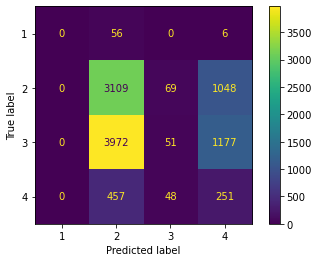

In [13]:
xg_model_sc = xg.sklearn.XGBClassifier()
xg_model_sc.fit(X_train_sc,y_train);
xg_preds_sc = xg_model_sc.predict(X_test_sc)
print_scores('XGBoost Scaled', bag, X_train_sc, y_train, X_test_sc, y_test, xg_preds_sc)
compare_preds(y,xg_preds_sc)

Decision Tree Scaled Accuracy Scores
-----------------------------------------------------
Decision Tree Scaled Training: 0.7991799277555404
Decision Tree Scaled Testing: 0.7883639203436158
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.78      0.82      0.80      4226
           3       0.80      0.88      0.84      5200
           4       0.55      0.06      0.11       756

    accuracy                           0.79     10244
   macro avg       0.53      0.44      0.44     10244
weighted avg       0.77      0.79      0.76     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.000098
2.0,0.412491,0.432936
3.0,0.507627,0.558376
4.0,0.073805,0.008590


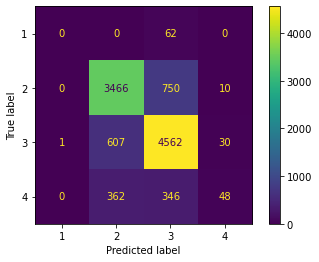

In [14]:
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=5)
tree.fit(X_train_sc,y_train)
tree_preds_sc = tree.predict(X_test_sc)
print_scores('Decision Tree Scaled', tree, X_train_sc, y_train, X_test_sc, y_test, tree_preds_sc)
compare_preds(y,tree_preds_sc)

Random Forrest Scaled Accuracy Scores
-----------------------------------------------------
Random Forrest Scaled Training: 0.7991799277555404
Random Forrest Scaled Testing: 0.7883639203436158
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        62
           2       0.80      0.81      0.80      4226
           3       0.78      0.90      0.84      5200
           4       0.75      0.02      0.03       756

    accuracy                           0.79     10244
   macro avg       0.58      0.43      0.42     10244
weighted avg       0.78      0.79      0.76     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.415267
2.0,0.412491,0.583171
3.0,0.507627,0.001562
4.0,0.073805,NaN


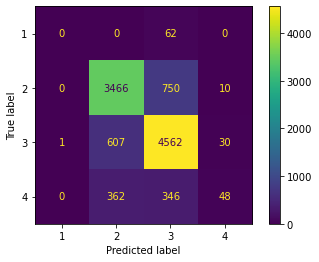

In [15]:
forrest = RandomForestClassifier(max_depth=10)
forrest.fit(X_train_sc,y_train)
forrest_preds_sc = forrest.predict(X_test_sc)
print_scores('Random Forrest Scaled', tree, X_train_sc, y_train, X_test_sc, y_test, forrest_preds_sc)
compare_preds(y,forrest_preds_sc)

BAG Classifier Scaled Accuracy Scores
-----------------------------------------------------
BAG Classifier Scaled Training: 0.991213511666504
BAG Classifier Scaled Testing: 0.8345372901210465
-----------------------------------------------------
Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           1       0.60      0.10      0.17        62
           2       0.83      0.86      0.84      4226
           3       0.84      0.88      0.86      5200
           4       0.80      0.41      0.54       756

    accuracy                           0.83     10244
   macro avg       0.77      0.56      0.60     10244
weighted avg       0.83      0.83      0.83     10244



,True Label Distribution,Predicted Label Distribution
Severity,,
1.0,0.006077,0.000976
2.0,0.412491,0.430203
3.0,0.507627,0.530847
4.0,0.073805,0.037973


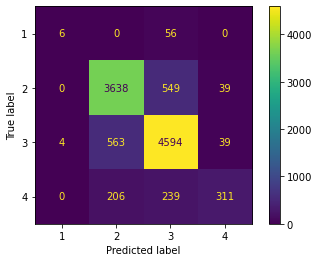

In [16]:
bag = BaggingClassifier(bootstrap_features=True)
bag.fit(X_train_sc,y_train)
bag_preds_sc = bag.predict(X_test_sc)
print_scores('BAG Classifier Scaled', bag, X_train_sc, y_train, X_test_sc, y_test, bag_preds_sc)
compare_preds(y,bag_preds_sc)